This file takes in cropped satellite image of a city and produces images chips and saves them as numpy arrays. I've used Sentinale image with a resolution of 10 meters and 'EPSG:32610 - WGS 84 / UTM zone 10N - Projected' CRS

The bands of the images are - blue, green, red, nir, ndvi

Other input is raster (.tif) with parks. It was created in qgis from vector data about the parks. It has the same resolution and crs as the satellite image

In [ ]:
#install packages
#!pip install pyrsgis
#!pip install rasterio
#!pip install patchify

In [ ]:
# Connecting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import rasterio
import numpy as np
from osgeo import gdal

# Open the file - san francisco:
image = gdal.Open('link to tif image')
park = gdal.Open('link to parks in tif image')

print(image)
print(park)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f9e7420b150> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f9e7420ba80> >


In [ ]:
# turn image into array
image_array = image.ReadAsArray()
print(image_array.shape)

#change negative ndvi values to 0
image_array[4][image_array[4] < 0] = 0
image_array = np.transpose(image_array, [1, 2, 0]) # transpose the bands to the third dimension
print(image_array.shape)

(5, 1385, 1452)
(1385, 1452, 5)


In [ ]:
#turn park into array
park_array = park.ReadAsArray()
park_array = np.expand_dims(park_array, axis = 2) #expand the dimention so it matched the sattelite images
print(park_array.shape)

(1385, 1452, 1)


In [ ]:
image_array[50][50] #pixel from the 50th row and 50th column

array([9.360000e+02, 9.000000e+02, 8.470000e+02, 2.275000e+03,
       4.573991e-01], dtype=float32)

patchify to create image patches

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#check the image array shape
image_array.shape

(1385, 1452, 5)

In [ ]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
#divide all images into patches 
patch_size = 256
step = 48
image_dataset = []  
scaler = MinMaxScaler()

#Extract patches from each image
patches_img = patchify(image_array, (patch_size, patch_size, 5), step=step)  #HERE ADD STRIDE
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:] 
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.     
    #print(single_patch_img.shape)                    
    image_dataset.append(single_patch_img) 
    #if you want to save each patch as separate image
    #image_to_save = np.transpose(single_patch_img, [2, 0, 1]) #transpose to put bands as the first one to save the image
    #tiff.imwrite('location to save the chips' + 'image_' + str(i)+ '_' +str(j)+ ".tif", image_to_save)
    #tiff.imwrite()

image_dataset = np.array(image_dataset)
image_dataset.shape

(600, 256, 256, 5)

In [ ]:
image_dataset[0][0][0]

array([0.09446567, 0.20483193, 0.16644235, 0.5351148 , 0.68572664],
      dtype=float32)

In [ ]:

#np.save('location to save image chips as numpy arrays', image_dataset)

and now for parks

In [ ]:
#divide all images into patches 
park_dataset = []  
scaler = MinMaxScaler()

#Extract patches from each image
patches_img = patchify(park_array, (patch_size, patch_size, 1), step=step)  #HERE ADD STRIDE
for i in range(patches_img.shape[0]):
  for j in range(patches_img.shape[1]):
    single_patch_img = patches_img[i,j,:,:] 
    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
    single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.     
    #print(single_patch_img.shape)                    
    park_dataset.append(single_patch_img) 
    #park_to_save = np.transpose(single_patch_img, [2, 0, 1]) #transpose to put bands as the first one to save the image
    #tiff.imwrite('location to save the chips' + 'image_' + str(i)+ '_' +str(j)+ ".tif", park_to_save)
    #tiff.imwrite()

park_dataset = np.array(park_dataset)
park_dataset.shape

(600, 256, 256, 1)

In [ ]:
#np.save('location to save park chips as numpy arrays', park_dataset)

In [ ]:
#check the datasets
print(image_dataset.max())
print(image_dataset.min())
print(np.unique(park_dataset))

1.0000001
0.0
[0. 1.]


In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

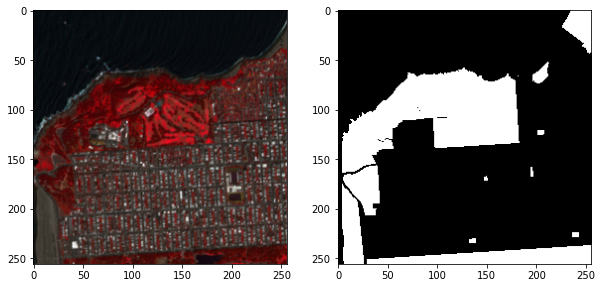

In [ ]:
# check whether the cropped images match

# generate random number
image_number = random.randint(0, len(image_dataset)-1)
plt.figure(figsize=(10, 5))

# plot satellite image with nir (more visible green areas then with true-color) 
plt.subplot(121)
img_r = image_dataset[image_number,:,:,3]
img_g = image_dataset[image_number,:,:,2]
img_b = image_dataset[image_number,:,:,1]
img_nir_col = np.dstack((img_r, img_g, img_b))
plt.imshow(img_nir_col)

# plot parks - white is park
plt.subplot(122)
plt.imshow(park_dataset[image_number,:,:,0], cmap='gray')
plt.show()